# Phase 5 — Deep Learning Model Development

Train improved deep learning models:
1. **FFNN with Residual Connections** - Better gradient flow
2. **CNN with Stability Improvements** - Learning rate scheduling, early stopping
3. **Autoencoder** - Anomaly detection (unchanged)

**Removed LSTM**: Too slow (~7.5+ hrs training) for minimal accuracy gains on tabular data.
Use gradient boosting or TabNet for sequential patterns instead.

In [ ]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, BatchNormalization, Input, Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load balanced training set
X = pd.read_csv("../data/processed/ml_balance/train_balanced.csv").values
y = pd.read_csv("../data/processed/ml_balance/train_balanced_labels.csv").values

# Ensure y is flat
if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
    y = y.ravel()
elif len(y.shape) > 1:
    y = y.ravel()

# Keep test set aside for final evaluation
X_test = pd.read_csv("../data/processed/ml_balance/test.csv").values
y_test = pd.read_csv("../data/processed/ml_balance/test_labels.csv").values
if isinstance(y_test, pd.DataFrame) and y_test.shape[1] == 1:
    y_test = y_test.ravel()
elif len(y_test.shape) > 1:
    y_test = y_test.ravel()

num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

DATA_DIR = Path("../data/processed/ml_balance")
MODEL_DIR = Path("../trained_models/dl_models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Number of classes: {num_classes}")
print(f"Deep learning models will be saved to {MODEL_DIR}")

# Define callbacks (used by all models)
def get_callbacks(model_name):
    return [
        EarlyStopping(
            monitor='val_loss', 
            patience=7, 
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=3, 
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            MODEL_DIR / f"{model_name}_best.keras",
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ]import psutil
import gc


In [ ]:
# ===================================================================
# Memory Optimization Utilities
# ===================================================================
import psutil
import gc

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024**3

def optimize_dtypes(df):
    """Reduce memory usage by optimizing data types"""
    print("\nOptimizing data types...")
    start_mem = df.memory_usage(deep=True).sum() / 1024**3
    print(f"  Initial memory: {start_mem:.2f} GB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**3
    saved = start_mem - end_mem
    print(f"  Final memory: {end_mem:.2f} GB")
    print(f"  Saved: {saved:.2f} GB ({100 * saved / start_mem:.1f}%)")
    
    return df

print(f"System RAM: {psutil.virtual_memory().total / 1024**3:.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.1f} GB")
print(f"Current process memory: {get_memory_usage():.2f} GB")

In [ ]:
# ============================================================
# FFNN with Residual Connections (Improved Architecture)
# ============================================================
print("=" * 60)
print("FFNN with Residual Connections")
print("=" * 60)

input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# First block
x = Dense(512, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Residual block 1
residual = Dense(256)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Residual connection
x = Dropout(0.3)(x)

# Residual block 2
residual = Dense(128)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Residual connection
x = Dropout(0.2)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

ffnn_residual = Model(input_layer, output, name='FFNN_Residual')
ffnn_residual.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(ffnn_residual.summary())

history_ffnn = ffnn_residual.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks('ffnn_residual'),
    verbose=1
)

ffnn_residual.save(MODEL_DIR / "final_ffnn_residual.keras")
print(f"\nSaved to {MODEL_DIR / 'final_ffnn_residual.keras'}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_ffnn.history['loss'], label='Train Loss')
axes[0].plot(history_ffnn.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('FFNN Residual - Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_ffnn.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_ffnn.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('FFNN Residual - Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# CNN with Improved Stability (Learning Rate Scheduling)
# ============================================================
print("=" * 60)
print("CNN with Stability Improvements")
print("=" * 60)

X_train_cnn = np.expand_dims(X_train, -1)
X_val_cnn = np.expand_dims(X_val, -1)
X_test_cnn = np.expand_dims(X_test, -1)

# Use cosine decay learning rate schedule
initial_learning_rate = 1e-3
decay_steps = len(X_train_cnn) // 256 * 30  # 30 epochs worth
lr_schedule = CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=1e-6
)

cnn_stable = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
], name='CNN_Stable')

# Compile with gradient clipping and scheduled learning rate
cnn_stable.compile(
    optimizer=Adam(learning_rate=lr_schedule, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(cnn_stable.summary())

history_cnn = cnn_stable.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val_cnn, y_val),
    callbacks=get_callbacks('cnn_stable'),
    verbose=1
)

cnn_stable.save(MODEL_DIR / "final_cnn_stable.keras")
print(f"\nSaved to {MODEL_DIR / 'final_cnn_stable.keras'}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_cnn.history['loss'], label='Train Loss')
axes[0].plot(history_cnn.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Stable - Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_cnn.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Stable - Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: LSTM removed due to excessive training time (7.5+ hours) for marginal gains.")
print("For sequential patterns, consider XGBoost or LightGBM with lag features instead.")

In [ ]:
# ============================================================
# Model Evaluation on Test Set
# ============================================================
print("=" * 60)
print("Evaluating Models on Test Set")
print("=" * 60)

from sklearn.metrics import classification_report, accuracy_score

# FFNN Residual
print("\n--- FFNN Residual ---")
y_pred_ffnn = ffnn_residual.predict(X_test, verbose=0)
y_pred_ffnn_classes = np.argmax(y_pred_ffnn, axis=1)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_ffnn_classes):.4f}")

# CNN Stable
print("\n--- CNN Stable ---")
y_pred_cnn = cnn_stable.predict(X_test_cnn, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_cnn_classes):.4f}")

# Detailed classification report for best model
print("\n" + "=" * 60)
print("Detailed Classification Report - FFNN Residual")
print("=" * 60)
print(classification_report(y_test, y_pred_ffnn_classes, digits=4))

[INFO] Loading dataset...
[INFO] Filtering BENIGN samples for training...
[INFO] Normal samples selected: 100000
[INFO] Scaling data...

---------------- Autoencoder (Anomaly Detection) ----------------
[INFO] Training autoencoder on normal data...
Epoch 1/50


d:\project\unified-ids-and-iot-security-system\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7250 - val_loss: 0.5784
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6945 - val_loss: 0.5775
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6938 - val_loss: 0.5762
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6936 - val_loss: 0.5761
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6933 - val_loss: 0.5760
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6931 - val_loss: 0.5757
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6929 - val_loss: 0.5763
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6928 - val_loss: 0.5756
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6928 - val_loss: 0.5755
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6927 - val_loss: 0.5755
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6919 - val_loss: 0.5735
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

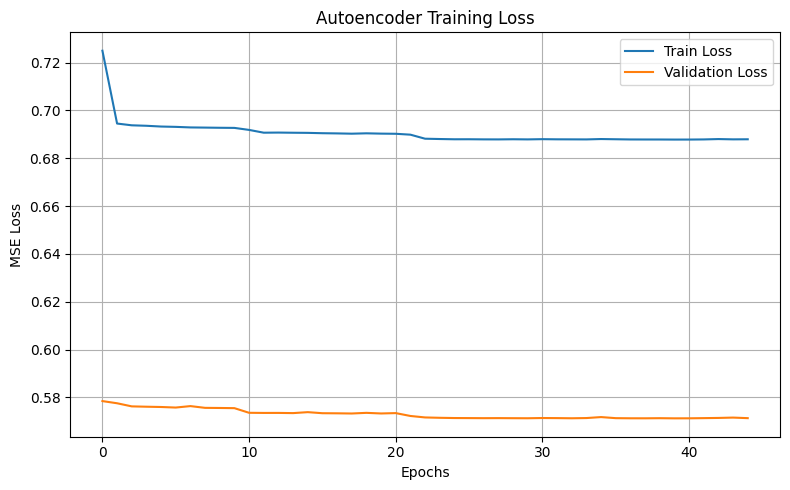


[INFO] Training complete. Model and scaler saved successfully.


In [12]:
# ---------------- Autoencoder ----------------

# Load dataset
# -------------------------------------------------------------------
print("[INFO] Loading dataset...")
df = pd.read_csv(DATA_DIR / "train_balanced.csv")
labels = pd.read_csv(DATA_DIR / "train_balanced_labels.csv")

if labels.shape[1] == 1:
    labels = labels.iloc[:, 0]

# -------------------------------------------------------------------
# Filter BENIGN (normal) samples only
# -------------------------------------------------------------------
print("[INFO] Filtering BENIGN samples for training...")

benign_mask = labels == 0

X_normal = df[benign_mask]

print(f"[INFO] Normal samples selected: {X_normal.shape[0]}")

# -------------------------------------------------------------------
# Scale features
# -------------------------------------------------------------------
print("[INFO] Scaling data...")
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# Save scaler for inference
joblib.dump(scaler, MODEL_DIR / "anormaly_scaler.joblib")

# -------------------------------------------------------------------
# Build Autoencoder
# -------------------------------------------------------------------
print("\n---------------- Autoencoder (Anomaly Detection) ----------------")

input_dim = X_normal_scaled.shape[1]

autoencoder = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# -------------------------------------------------------------------
# Train Model
# -------------------------------------------------------------------
print("[INFO] Training autoencoder on normal data...")

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_normal_scaled, X_normal_scaled,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------------------------------------------
# Save Model
# -------------------------------------------------------------------
MODEL_PATH = MODEL_DIR / "anomaly_autoencoder.keras"
autoencoder.save(MODEL_PATH)
print(f"[INFO] Saved trained autoencoder to {MODEL_PATH}")

# -------------------------------------------------------------------
# Determine Reconstruction Error Threshold
# -------------------------------------------------------------------
reconstructions = autoencoder.predict(X_normal_scaled)
mse = np.mean(np.power(X_normal_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)

print(f"[INFO] Calculated anomaly threshold (95th percentile): {threshold:.6f}")

np.save(MODEL_DIR / "anomaly_threshold.npy", threshold)

# -------------------------------------------------------------------
# Plot Training Loss
# -------------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n[INFO] Training complete. Model and scaler saved successfully.")